# Treasury squeeze

Very elementary stuff - I believe this was for a class. I was unable to find the dataset I used.

In [3]:
import umap.plot
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split

In [4]:
data = pd.read_csv("../data/Treasury Squeeze raw score data.csv")
data = data.drop(columns=["rowindex", "contract"])
features = data.drop(columns=["squeeze"])
labels = data["squeeze"]
X_train, X_test, y_train, y_test = train_test_split(features.values, labels.values, test_size=0.25)
display(data.info())
display(data.head())
print(f"Label bias: {round(labels.sum()/len(labels),3)}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   price_crossing    900 non-null    float64
 1   price_distortion  900 non-null    float64
 2   roll_start        900 non-null    float64
 3   roll_heart        900 non-null    float64
 4   near_minus_next   900 non-null    float64
 5   ctd_last_first    900 non-null    float64
 6   ctd1_percent      900 non-null    float64
 7   delivery_cost     900 non-null    float64
 8   delivery_ratio    900 non-null    float64
 9   squeeze           900 non-null    bool   
dtypes: bool(1), float64(9)
memory usage: 64.3 KB


None

,price_crossing,price_distortion,roll_start,roll_heart,near_minus_next,ctd_last_first,ctd1_percent,delivery_cost,delivery_ratio,squeeze
0,0.157659,0.900783,0.016053,1.000000,1.000000,0.902811,1.000000,0.010743,0.099313,True
1,0.018588,1.000000,1.000000,0.084724,0.778847,1.000000,0.136069,0.154116,1.000000,False
2,0.035755,0.045987,0.673543,1.000000,0.027689,0.067889,0.007696,0.034743,0.171676,False
3,0.663832,1.000000,0.063057,0.188899,0.064454,0.005742,0.166102,0.956668,1.000000,True
4,0.109678,0.113601,0.726244,1.000000,1.000000,1.000000,1.000000,0.105467,0.145025,False


Label bias: 0.427


## Visualizing the data

I will first use [umap](https://umap-learn.readthedocs.io/en/latest/index.html) to get a dimensionally reduced plot of
the data and get a feel for its topology. 9 columns is a few too many for pair plots to be very meaningful but I will generate them nonetheless.

C:\Users\Bora\anaconda3\envs\tensorflow_projects\lib\site-packages\umap\plot.py:854: UserWarning: Hammer edge bundling is expensive for large graphs!
This may take a long time to compute!
  warn(


<AxesSubplot:>

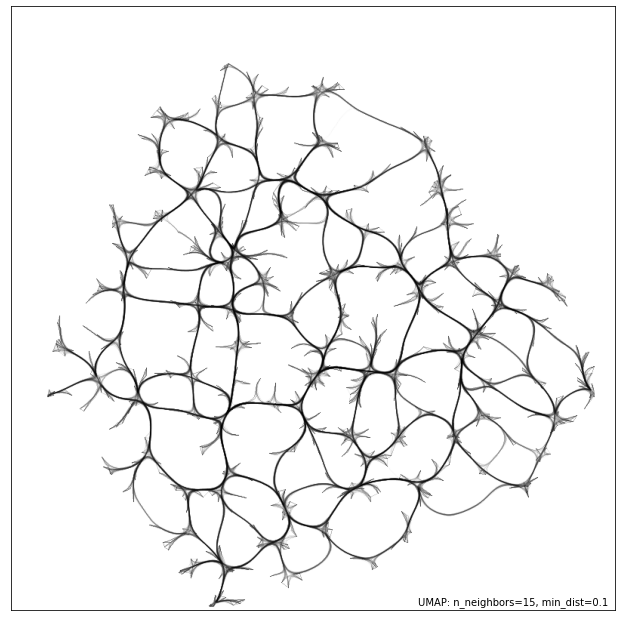

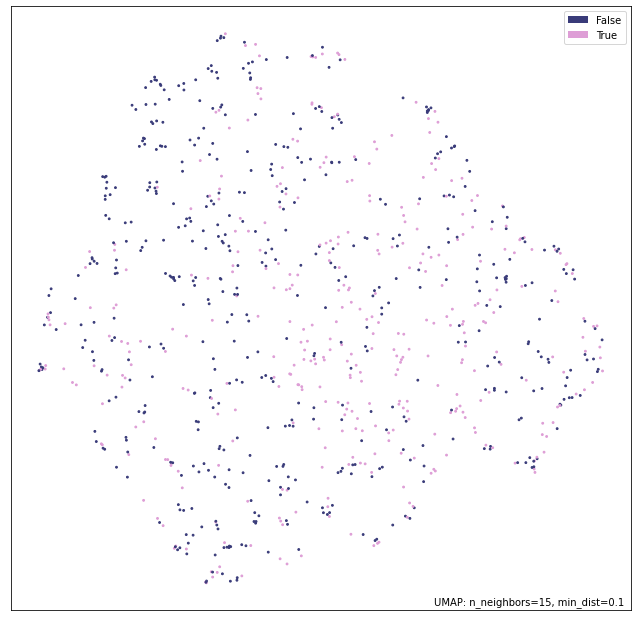

In [5]:
embedding = umap.UMAP().fit(features)
umap.plot.connectivity(embedding, labels=labels, edge_bundling="hammer", theme="red", color_key_cmap='fire', background='white')
umap.plot.points(embedding, labels=labels, theme="red", color_key_cmap='fire', background='white')

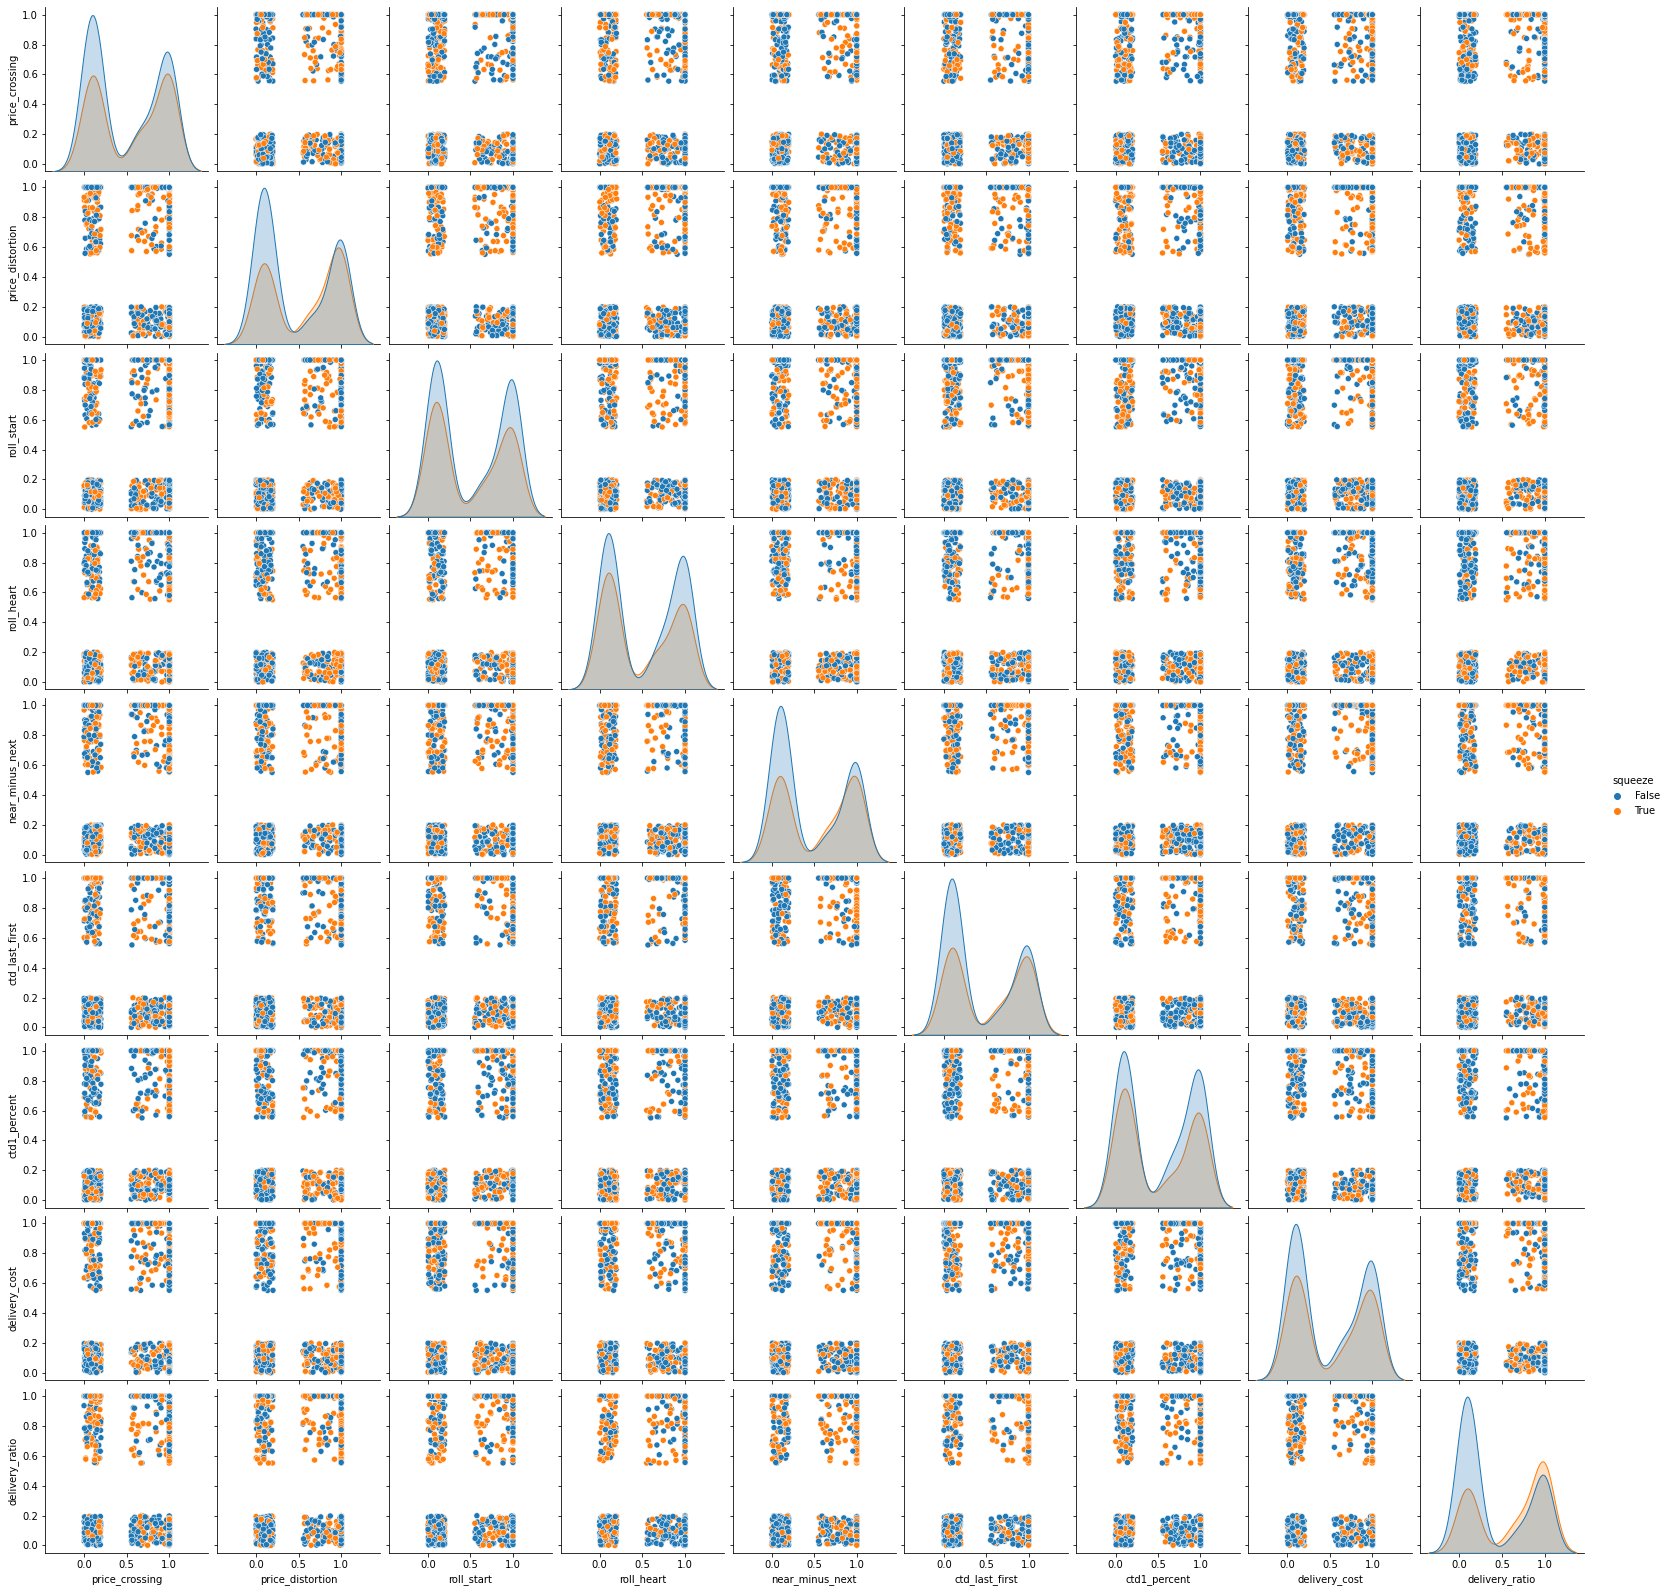

In [6]:
sns.pairplot(data, hue='squeeze')

These plots indicate that there are no clear decision boundaries to be drawn so we shouldn't expect phenomenal performance
from our linear model.

### KNN classifier set up

Let's use a simple pipeline that passes an array of standardized features into the SGD classifier. What's not shown here
is the optimization I did with different PCA components.

In [15]:

params = {"kneighborsclassifier__n_neighbors":np.arange(2,6), "kneighborsclassifier__p":[1, 2],
          "kneighborsclassifier__leaf_size":np.arange(10,40, 1)}
clf = lambda n: make_pipeline(StandardScaler(), PCA(n_components=n), KNeighborsClassifier(n_jobs=-1))
print(clf(9))

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=9)),
                ('kneighborsclassifier', KNeighborsClassifier(n_jobs=-1))])


### Model training
I'll be using a simple grid search for tuning with
stratified K-fold cross validation (due to the label bias). We'll loop through the number of neighbours, leaf sizes
and the power parameter.

In [16]:
grid = GridSearchCV(clf(8), param_grid=params, cv=StratifiedKFold(n_splits=7), verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)
optimal_knn = grid.best_estimator_["kneighborsclassifier"]

Fitting 7 folds for each of 240 candidates, totalling 1680 fits


In [17]:
print('Best cross validation score: %.2f'%grid.best_score_, ' Best Params : ', str(grid.best_params_))
print("Best test accuracy score",round(grid.best_estimator_.score(X_test, y_test), 3))
# print("Weights", optimal_SGD.coef_[0])
# print("Intercept", optimal_SGD.intercept_[0])

Best cross validation score: 0.61  Best Params :  {'kneighborsclassifier__leaf_size': 10, 'kneighborsclassifier__n_neighbors': 4, 'kneighborsclassifier__p': 1}
Best test accuracy score 0.604


### Decision boundaries

In [ ]:
u = grid.best_estimator_["pca"].transform(grid.best_estimator_["standardscaler"].transform(features))
x, y = np.linspace(u[:,0].min()-0.1, u[:,0].max()+0.1, 30), np.linspace(u[:,1].min()-0.1, u[:,1].max()+0.1, 30)
x_mesh, y_mesh = np.meshgrid(x, y)

plt.figure(figsize=(15, 15))
plt.scatter(u[:,0], u[:,1], c=labels, cmap="PiYG", edgecolor='k', s=200);
plt.contourf(x_mesh, y_mesh, grid.best_estimator_.predict(features).reshape(x_mesh.shape), alpha=0.3, cmap="PiYG");

### Working only with 2 principal components

I threw in a PCA element to the pipeline to see if we could get away with fitting a smaller problem. The couple tuning
experiments I ran showed that the accuracy of the model was a rather weak function of PCA components. This being the case,
we can drop down to the 2 principle components and see what we get

In [18]:
grid_2d = GridSearchCV(clf(2), param_grid=params, cv=StratifiedKFold(n_splits=7), verbose=1, n_jobs=-1)
grid_2d.fit(X_train, y_train)
print('Best cross validation score: %.2f'%grid_2d.best_score_, ' Best Params : ', str(grid_2d.best_params_))
print("Best test accuracy score",round(grid_2d.best_estimator_.score(X_test, y_test), 3))

Fitting 7 folds for each of 240 candidates, totalling 1680 fits
Best cross validation score: 0.56  Best Params :  {'kneighborsclassifier__leaf_size': 10, 'kneighborsclassifier__n_neighbors': 4, 'kneighborsclassifier__p': 1}
Best test accuracy score 0.622


C:\Users\Bora\anaconda3\envs\tensorflow_projects\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


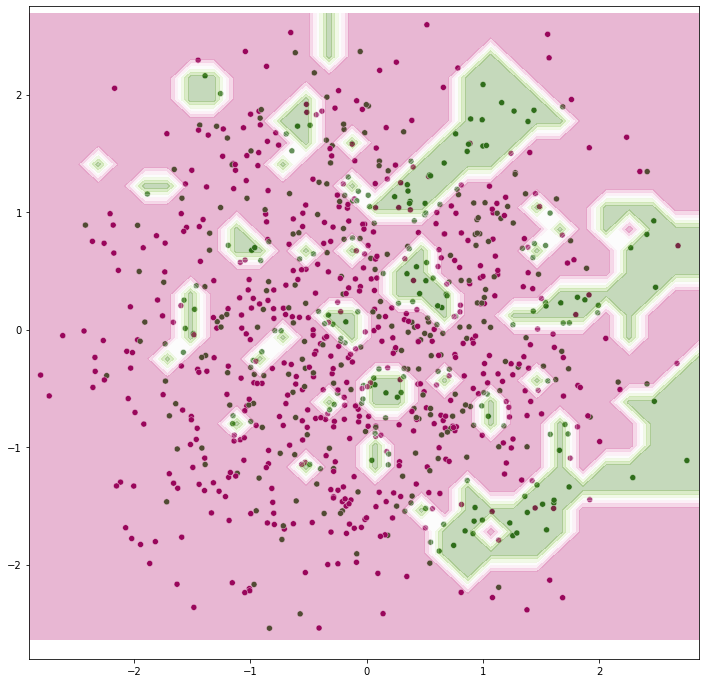

In [25]:
u = grid_2d.best_estimator_["pca"].transform(grid_2d.best_estimator_["standardscaler"].transform(features))
x = np.linspace(u[:,0].min()-0.1, u[:,0].max()+0.1, 30)
y = np.linspace(u[:,1].min()-0.1, u[:,1].max()+0.1, 30)
x_mesh, y_mesh = np.meshgrid(x, y)

plt.figure(figsize=(12, 12))
sns.scatterplot(u[:,0], u[:,1], c=labels, cmap="PiYG")
plt.ylim((u[:,0].min(),u[:,0].max()))
plt.contourf(x_mesh, y_mesh, grid_2d.best_estimator_["kneighborsclassifier"].predict(np.c_[x_mesh.ravel(), y_mesh.ravel()]).reshape(x_mesh.shape), alpha=0.3, cmap="PiYG");
